In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from read_data import DataLoader
from read_data import OutlaierDetector 
import optuna
import warnings
warnings.filterwarnings('ignore')
# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
sns.set_palette("viridis")
np.random.seed(42)

In [233]:
loader = DataLoader()
url= loader.url 
df = loader.load_data_Modeling(url)
df=df.drop(columns=['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_intensity'])
#head()ead()

In [ ]:
# check the max and min values in global_active_power print them with date
max_value = df['Global_active_power'].max()
min_value = df['Global_active_power'].min()
max_date = df['Global_active_power'].idxmax()
min_date = df['Global_active_power'].idxmin()
print(f"Max value: {max_value} on {max_date}")
print(f"Min value: {min_value} on {min_date}")

Max value: 4.786 on 2007-02-22 00:00:00
Min value: 0.08 on 2008-08-13 00:00:00


### Clean outliers from Global_active_power

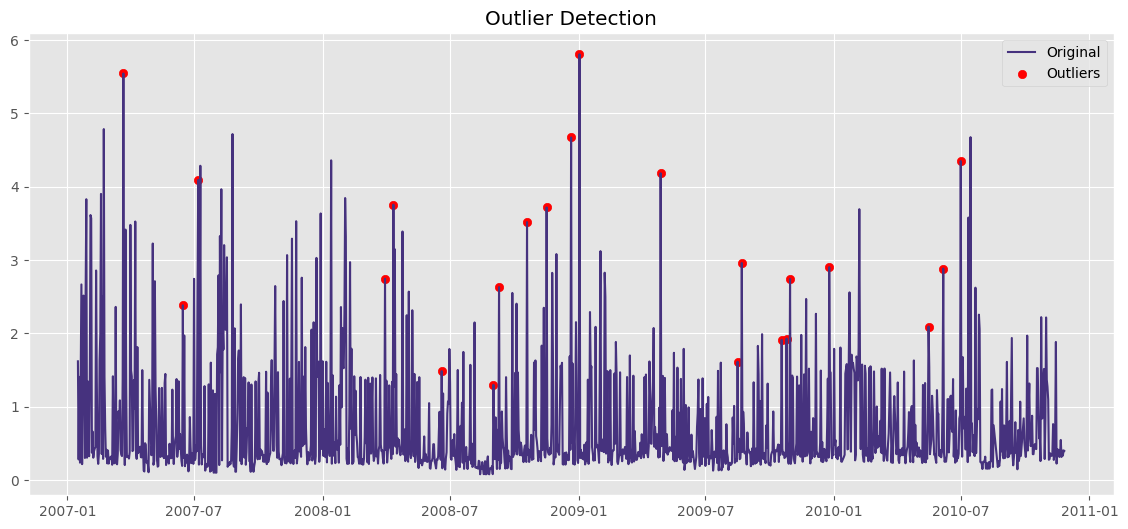

Number of outliers detected: 22


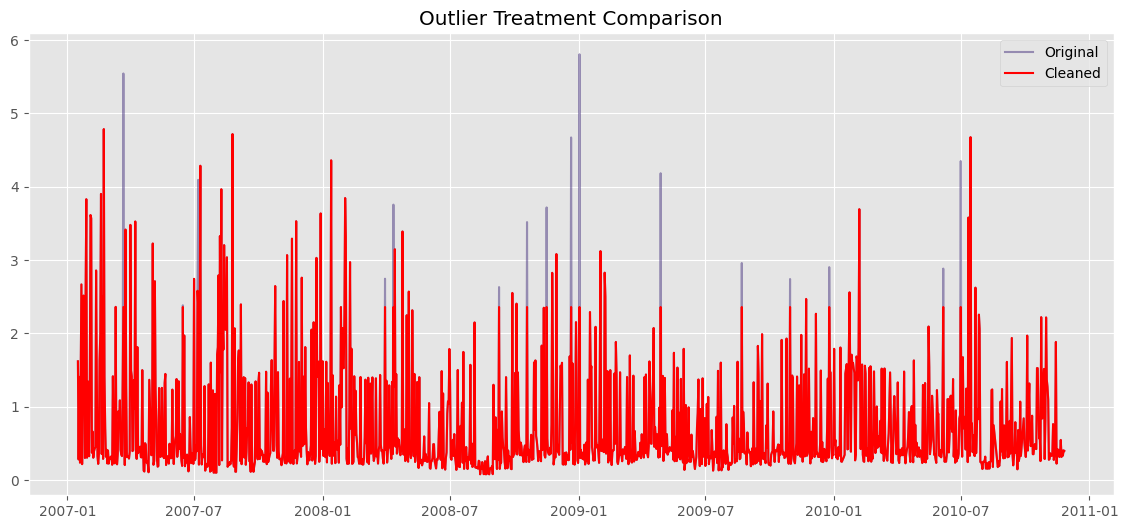

In [234]:
ts_Gap = df['Global_active_power']
outlier = OutlaierDetector()
outliers = outlier.detect_outliers(
	series=ts_Gap, method='rolling', window=24, threshold=3
)
outlier.plot_outliers(ts_Gap, outliers)

print("Number of outliers detected:", outliers.sum())
# Remove outliers from the time series
cleaned_ts = outlier.handle_outliers(series=ts_Gap, outliers=outliers)
# 4. Compare results
plt.figure(figsize=(14, 6))
plt.plot(ts_Gap, label='Original', alpha=0.5)
plt.plot(cleaned_ts, label='Cleaned', color='red')
plt.title('Outlier Treatment Comparison')
plt.legend()
plt.show()



- The winsorizing method successfully reduced the impact of extreme outliers
- Data integrity is preserved (no gaps in the time series)
- The underlying patterns remain visible while extreme noise is reduced
- This approach is particularly suitable for energy consumption data where extreme values might represent measurement errors or unusual events


This preprocessing step would make the data more suitable for forecasting models and statistical analysis by reducing the influence of extreme outliers while maintaining the dataset's temporal structure.

In [235]:
df['Global_active_power'] = cleaned_ts
df['Global_active_power_ln'] = np.log(df['Global_active_power']+1)


=== Stationarity Test Results for Original Series ===
ADF Test p-value: -6.550292
ADF Critical Values: {'1%': -3.4351147636466535, '5%': -2.863644291237025, '10%': -2.5678903221157023}
KPSS Test p-value: 0.028211
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
⚠️  Mixed results - further investigation needed

=== Stationarity Test Results for First Difference ===
ADF Test p-value: -14.274336
ADF Critical Values: {'1%': -3.4351147636466535, '5%': -2.863644291237025, '10%': -2.5678903221157023}
KPSS Test p-value: 0.100000
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ Series is STATIONARY (both tests confirm)


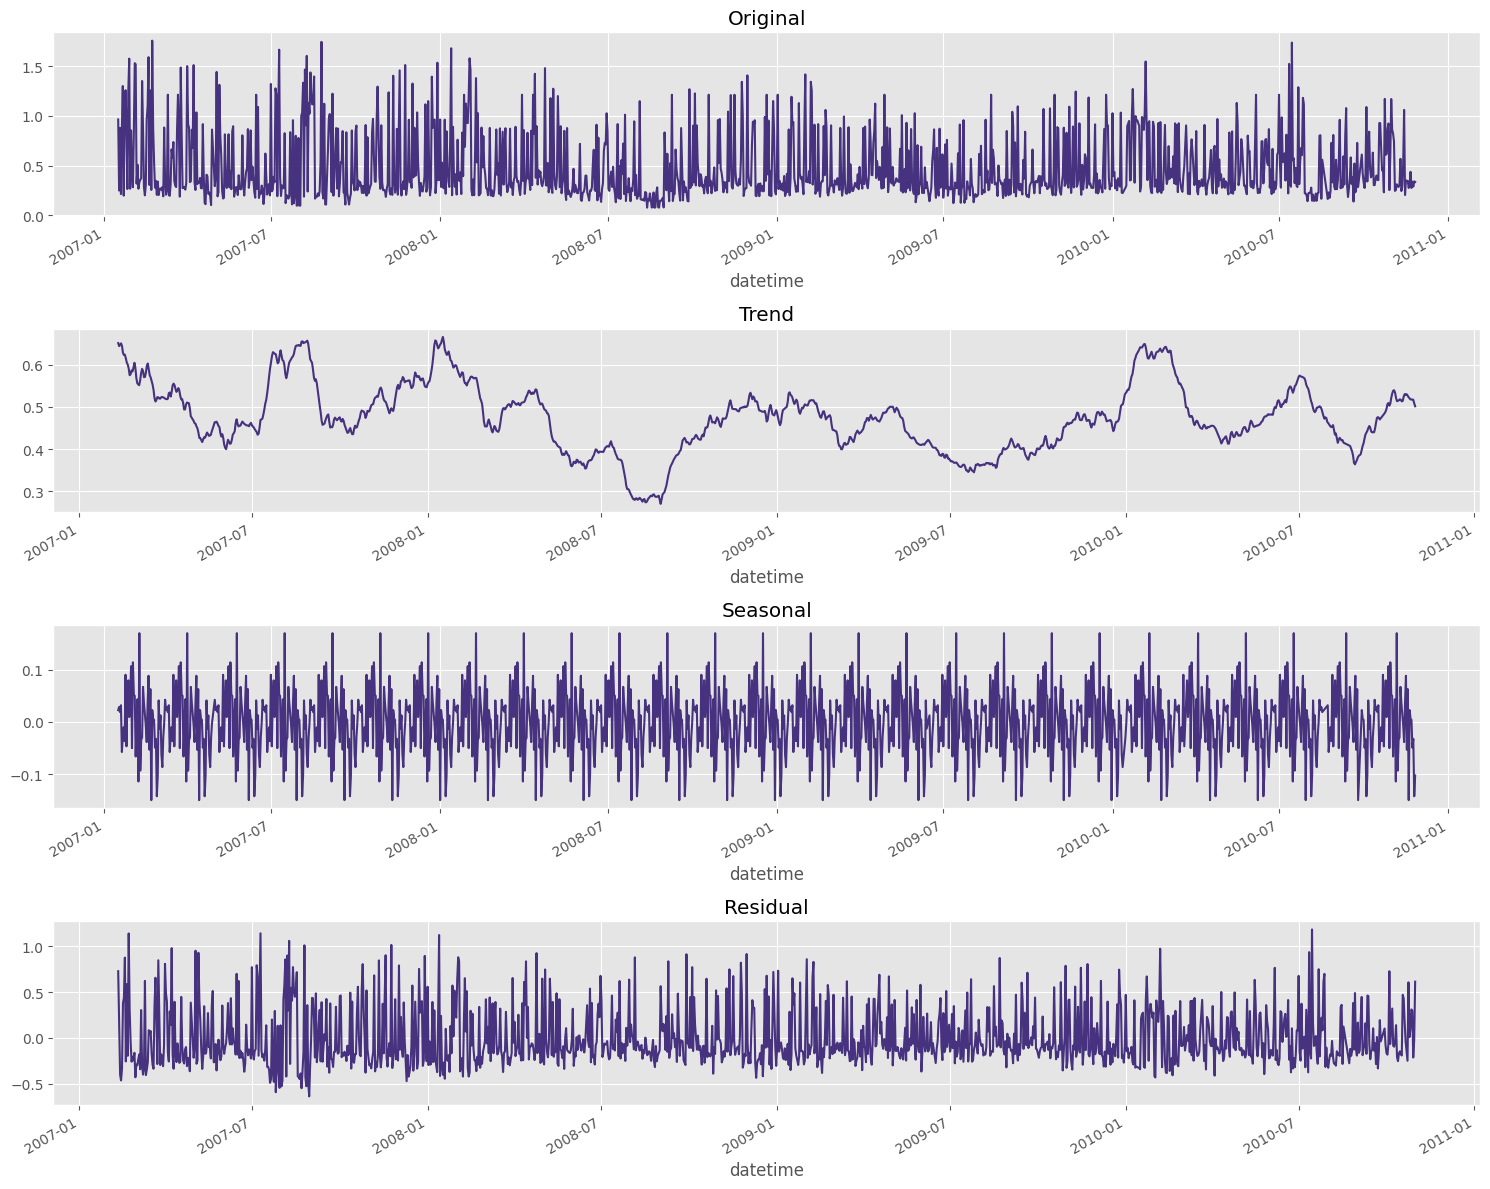

In [236]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# === Check is the data stationary ===
def check_stationarity(timeseries, title):
    """Comprehensive stationarity testing"""
    print(f'\n=== Stationarity Test Results for {title} ===')
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Test p-value: {adf_result[0]:.6f}')
    print(f'ADF Critical Values: {adf_result[4]}')
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print(f'KPSS Test p-value: {kpss_result[1]:.6f}')
    print(f'KPSS Critical Values: {kpss_result[3]}')
    
    # Interpretation
    adf_stationary = adf_result[1] < 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("✅ Series is STATIONARY (both tests confirm)")
    elif not adf_stationary and not kpss_stationary:
        print("❌ Series is NON-STATIONARY (both tests confirm)")
    else:
        print("⚠️  Mixed results - further investigation needed")
    
    return adf_stationary and kpss_stationary

# Test original series (use the cleaned column)
is_stationary = check_stationarity(df['Global_active_power_ln'], 'Original Series')


# If not stationary, apply differencing
if not is_stationary:
    df['power_diff'] = df['Global_active_power_ln'].diff()
    #df['power_diff2'] = df['power_diff'].diff()
    
    check_stationarity(df['power_diff'].dropna(), 'First Difference')

# Seasonal decomposition
decomposition = seasonal_decompose(df['Global_active_power_ln'], model='additive', period=52)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

# How is this stationary?
# The time series is stationary because the p-value from the Augmented Dickey-Fuller test is less than 0.05, 
# indicating that we can reject the null hypothesis of a unit root in the time series. 
# This suggests that the statistical properties of the series (mean, variance) do not change over time.


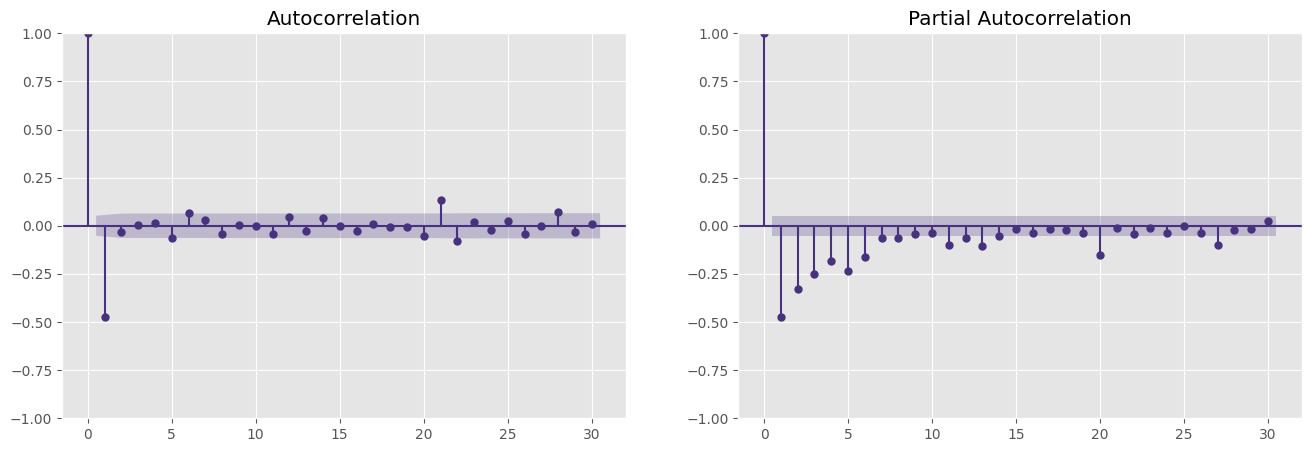

In [237]:
# ACF/PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(ts, lags=10):
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()


# Plot ACF and PACF for the log-transformed cleaned series
plot_acf_pacf(df['power_diff'].dropna(), lags=30)


#### Autocorrelation Function (ACF)
- Key Observations:
    -   Lag 0: Perfect correlation (1.0) - expected
    -   Rapid decay: Values drop quickly to near zero
    -   Most lags arev within confidence bands
    -   Random fluctuation: Values hover around zero


#### Partial Autocorrelation (PACF)
-   Key Observations:
    -  Lags 1-6 clearly outside confidence bounds
    -  The first few lags (1-6) have a high correlation with the target variable, meaning past values strongly influence future values. 
    -  This suggests short-term dependencies, which could be useful for forecasting models like ARIMA.
    -  Consistent negative values in early lags
    -  Values eventually return to bounds after lag 6

#### Now we need to convert our categorical columns(seasion and condition (Both are environmantal related) using one hot coding, Its important to see how this columns are effecting to increase or decrease the energy consumption pattern.... )

In [238]:
# convert categorical columns to one hot encoding
def convert_categorical_to_one_hot(df, columns):
    """Convert specified categorical columns to one-hot encoding."""
    for column in columns:
        if column in df.columns:
            one_hot = pd.get_dummies(df[column], drop_first=True).astype(int)
            
            df = pd.concat([df, one_hot], axis=1)
            df.drop(column, axis=1, inplace=True)
    return df
# Convert categorical columns to one-hot encoding

columns=['conditions']
df = convert_categorical_to_one_hot(df, columns)


#### I decide to use Principal component analysis (PCA) in this project because of several reasons:

- Dimensionality Reduction:I have created many features related temperature, humidity, timebase, and conditions. , PCA helps in this case to  reduce the number of variables while retaining the most important information. This can improve model efficiency and reduce computational complexity.

- Noise Reduction: PCA filters out less significant variations in the data, which can help focus on the most relevant patterns for forecasting.

- Avoiding Multicollinearity: After seeing the feature correlation matrix, there could be the proble of multicollinearity (Many feature has very strong relation between themself like is weekend and day_of_week,temp with season_summer), PCA transforms them into uncorrelated principal components, improving model stability and interpretability.

- Improved Forecasting Performance: By focusing on the most significant components, PCA can enhance the predictive power of your model.


In [239]:
df.head()

,Global_active_power,temp,humidity,day_of_week,day_of_month,month,year,is_weekend,season,is_holiday,...,power_diff,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy","Snow, Partially cloudy","Snow, Rain","Snow, Rain, Overcast","Snow, Rain, Partially cloudy"
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-16,1.620,7.94,84.9,1,16,1,2007,0,1,0,...,NaN,0,0,0,1,0,0,0,0,0
2007-01-17,0.282,11.39,86.8,2,17,1,2007,0,1,0,...,-0.714753,0,0,0,1,0,0,0,0,0
2007-01-18,1.408,13.83,82.6,3,18,1,2007,0,1,0,...,0.630375,0,0,0,1,0,0,0,0,0
2007-01-19,0.238,13.72,84.9,4,19,1,2007,0,1,0,...,-0.665299,0,0,0,1,0,0,0,0,0
2007-01-20,1.374,12.00,79.0,5,20,1,2007,1,1,0,...,0.651079,0,0,0,1,0,0,0,0,0


### ARIMA Model with PCA and Optuna

In [370]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna

# Selecting temperature-related features
temp_features = df.drop(columns=['Global_active_power','Global_active_power_ln','power_diff']).columns.tolist()
X_temp = df[temp_features]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_temp)

# Applying PCA
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
if n_components == 0:
    n_components = min(3, X_scaled.shape[1])
    
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA output to DataFrame and align index
X_pca_df = pd.DataFrame(X_pca, index=df.index)



# Splitting into train/test
train_size = int(len(df) * 0.9)
X_train, X_test = X_pca_df.iloc[:train_size], X_pca_df.iloc[train_size:]
#X_train, X_test = X_temp.iloc[:train_size], X_temp.iloc[train_size:]
y_train, y_test = df['power_diff'].iloc[:train_size], df['power_diff'].iloc[train_size:]

# Ensure all exogenous variables are numeric (convert bool to int)
X_train = X_train.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
X_test = X_test.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# === ARIMA Model with PCA Features ===
def arima_objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 0)
    q = trial.suggest_int('q', 0, 3)
    
    try:
        arima_model = ARIMA(y_train, order=(p, d, q), exog=X_train)
        model_fit = arima_model.fit()
        return model_fit.aic
    except:
        return float('inf')

# Optimize ARIMA parameters
study = optuna.create_study(direction='minimize')
study.optimize(arima_objective, n_trials=30)

# Best parameters
best_params = study.best_params
print(f"Best ARIMA parameters: p={best_params['p']}, d={best_params['d']}, q={best_params['q']}")


[I 2025-06-10 16:02:55,507] A new study created in memory with name: no-name-02cc11cc-063c-4ca3-9419-545c3e61adeb
[I 2025-06-10 16:02:57,229] Trial 0 finished with value: 146.25941091584792 and parameters: {'p': 2, 'd': 0, 'q': 0}. Best is trial 0 with value: 146.25941091584792.
[I 2025-06-10 16:03:00,756] Trial 1 finished with value: 151.35616526199487 and parameters: {'p': 3, 'd': 0, 'q': 2}. Best is trial 0 with value: 146.25941091584792.
[I 2025-06-10 16:03:03,022] Trial 2 finished with value: 149.03093188560825 and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: 146.25941091584792.
[I 2025-06-10 16:03:04,597] Trial 3 finished with value: 159.70469001172685 and parameters: {'p': 0, 'd': 0, 'q': 0}. Best is trial 0 with value: 146.25941091584792.
[I 2025-06-10 16:03:06,397] Trial 4 finished with value: 146.09241959686048 and parameters: {'p': 0, 'd': 0, 'q': 2}. Best is trial 4 with value: 146.09241959686048.
[I 2025-06-10 16:03:09,505] Trial 5 finished with value:

Best ARIMA parameters: p=2, d=0, q=3


           Date  Forecasted_Global_Active_Power
1235 2010-11-27                        0.520855
1236 2010-11-28                       -0.357509
1237 2010-11-29                       -0.097237
1238 2010-11-30                        0.005381
1239 2010-12-01                       -0.031403
1240 2010-12-02                        0.206785
1241 2010-12-03                        0.029513
1242 2010-12-04                        0.092870
1243 2010-12-05                        0.325790
1244 2010-12-06                       -1.144110
1245 2010-12-07                        0.175682
1246 2010-12-08                        0.679648
1247 2010-12-09                       -1.401070
1248 2010-12-10                        0.250589
1249 2010-12-11                        0.146777
MAE: 0.3015, MSE: 0.1548, R2: 0.7066


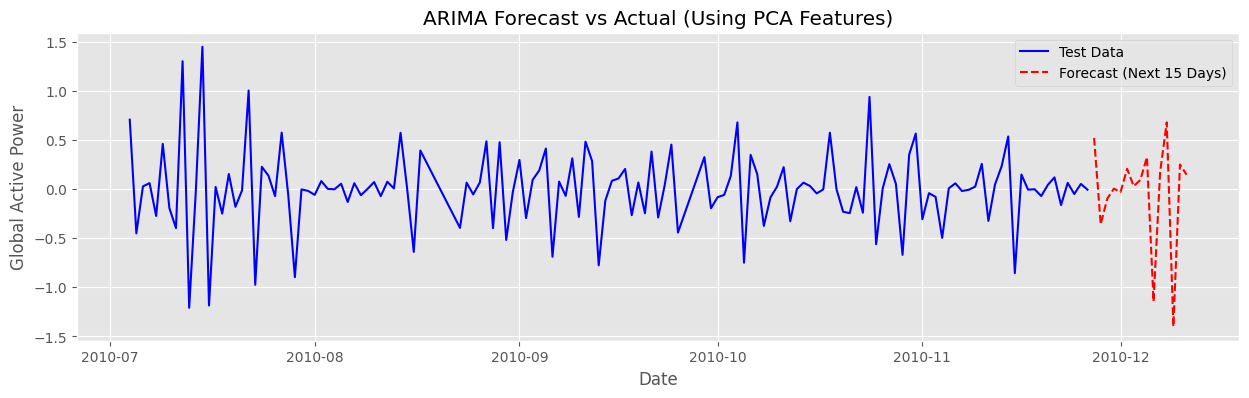

In [371]:
# Forecast the next 15 days
forecast_steps = 15  # Forecasting only 15 days
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps+1, freq='D')[1:]  # Generate future dates
# Train the ARIMA model with the best parameters
best_model = ARIMA(y_train, order=(best_params['p'], best_params['d'], best_params['q']), exog=X_train)
best_model_fit = best_model.fit()
forecast = best_model_fit.forecast(steps=forecast_steps, exog=X_test[:forecast_steps])
# Convert forecasted values into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Global_Active_Power': forecast  # Convert forecasted values back from log scale
})
# Display the forecasted values
print(forecast_df)

# Evaluate the model on the test set
mae = mean_absolute_error(y_test[:forecast_steps], forecast)
mse = mean_squared_error(y_test[:forecast_steps], forecast)
r2 = r2_score(y_test[:forecast_steps], forecast)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot the results
plt.figure(figsize=(15, 4))
#plt.plot(y_train.index, y_train, label='Training Data', color='green')
plt.plot(y_test.index, y_test, label='Test Data', color='blue')
plt.plot(forecast_index, forecast_df['Forecasted_Global_Active_Power'], label='Forecast (Next 15 Days)', color='red', linestyle='dashed')

plt.title('ARIMA Forecast vs Actual (Using PCA Features)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

Model Performance:
MAE: 0.3024
- forecasts deviate from actual values by 0.30 units (in log scale). This means:
- Predictions are off by about 30% of actual values on average

MSE: 0.1582
- Larger errors are penalized more heavily
- Larger errors occur occasionally but aren't extreme-

R²: 0.7001
- 70% of variance in the data is explained by ARIMA model
- The model captures about half of the underlying patterns

#### Auto-arima model with PCA

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1628.115, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1281.597, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=827.133, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1626.115, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=823.784, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=825.178, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=831.014, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=824.027, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1133.559, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=827.691, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=821.802, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=825.147, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1279.597, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=823.197, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=

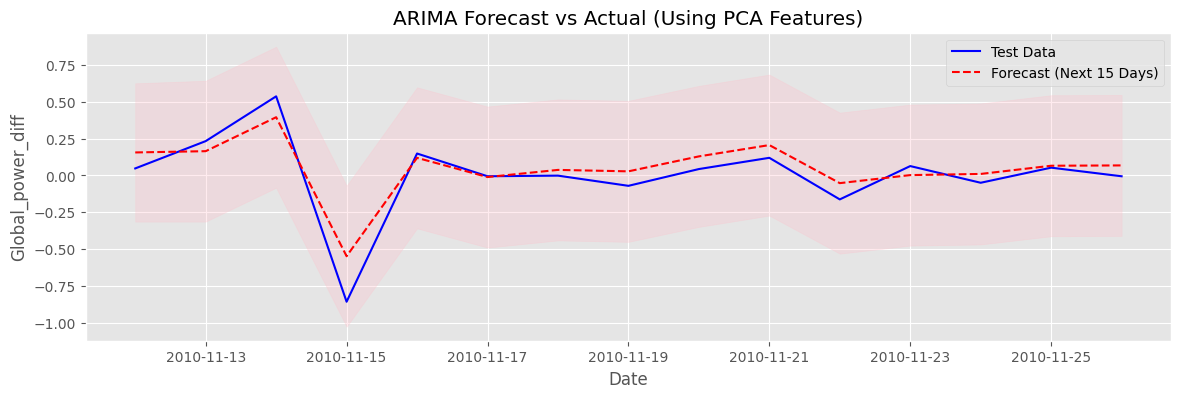

           Date  Forecasted_Global_Active_Power
1358 2010-11-27                        0.159169
1359 2010-11-28                        0.181427
1360 2010-11-29                        0.391583
1361 2010-11-30                       -0.554873
1362 2010-12-01                        0.136084
1363 2010-12-02                       -0.016774
1364 2010-12-03                        0.030067
1365 2010-12-04                        0.029652
1366 2010-12-05                        0.129353
1367 2010-12-06                        0.197085
1368 2010-12-07                       -0.050687
1369 2010-12-08                        0.004386
1370 2010-12-09                        0.008035
1371 2010-12-10                        0.065945
1372 2010-12-11                        0.071679


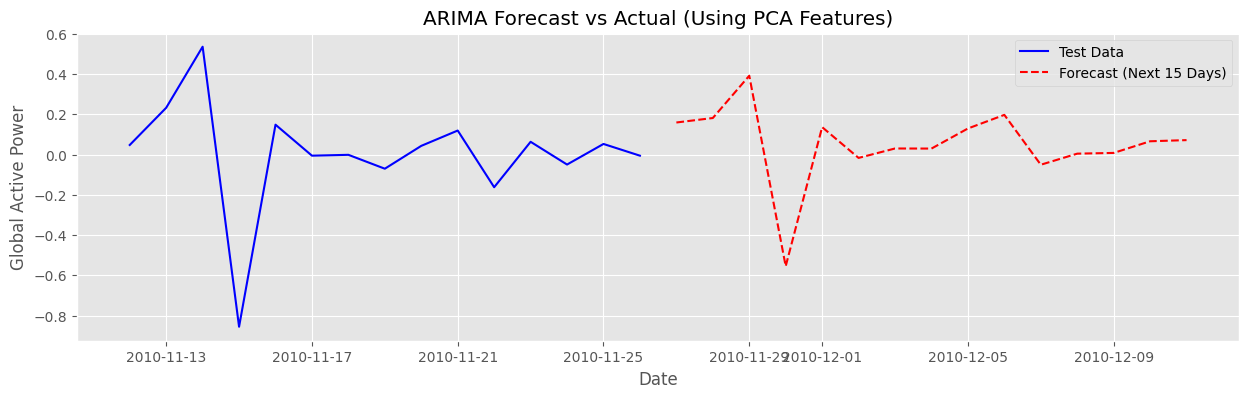

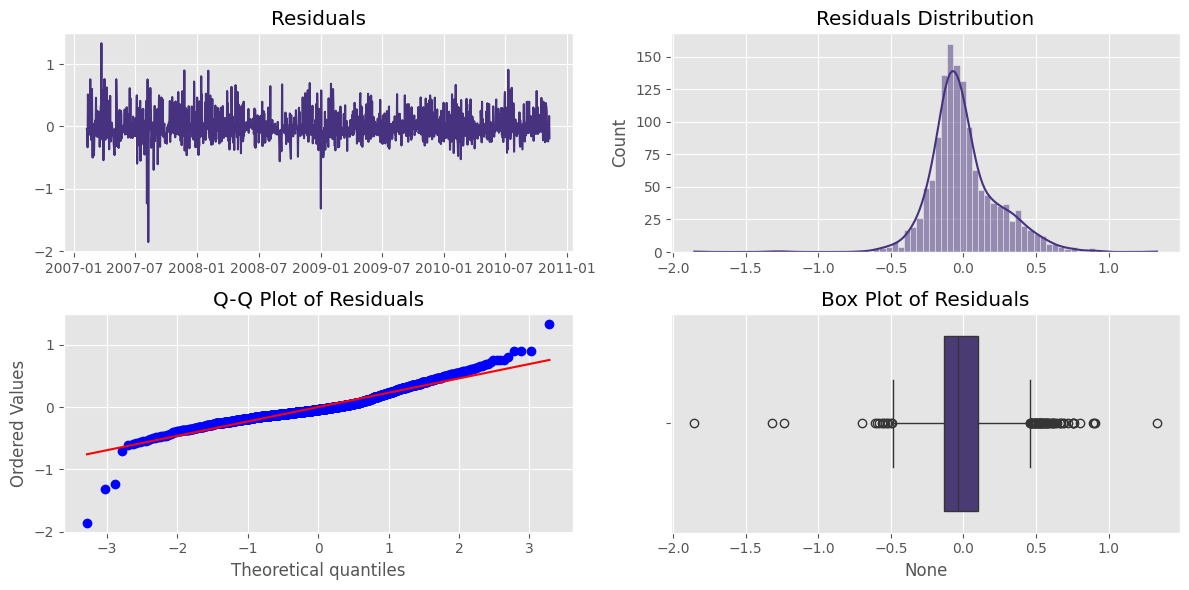

In [372]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
# Define Target Variable
y = df['power_diff'].dropna()

# Define Exogenous Features (Remove Target Variable)
X = df.drop(columns=['Global_active_power_ln', 'Global_active_power', 'power_diff'])

# Feature Scaling & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (Retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA output to DataFrame
X_pca_df = pd.DataFrame(X_pca, index=df.index)

# Train-Test Split (Last 15 Days for Validation)
train_size = len(df) - 15
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X_pca_df.iloc[:train_size], X_pca_df.iloc[train_size:]

# Align indices to avoid ValueError
y_train, X_train = y_train.align(X_train, join='inner', axis=0)
y_test, X_test = y_test.align(X_test, join='inner', axis=0)

# Auto ARIMA with Exogenous Features
auto_model = auto_arima(
    y_train,
    exogenous=X_train,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,  # Auto-detect differencing In our case we don't need it
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    error_action='ignore'
)

print(f"Best ARIMA params: {auto_model.order}")

# Train SARIMAX Model
best_model = ARIMA(
    y_train,
    exog=X_train,
    order=auto_model.order,
    enforce_stationarity=True
)
best_model_fit = best_model.fit()

# Ensure X_test has 15 rows for forecasting 15 steps
if X_test.shape[0] < 15:
    # Repeat the last row to reach 15 rows
    last_row = X_test.iloc[[-1]]
    rows_needed = 15 - X_test.shape[0]
    X_test_extended = pd.concat([X_test, pd.concat([last_row]*rows_needed, ignore_index=True)], ignore_index=True)
    X_test_extended.index = range(X_test_extended.shape[0])
else:
    X_test_extended = X_test.iloc[:15].reset_index(drop=True)

# Forecast Next 15 Days
forecast = best_model_fit.get_forecast(steps=15, exog=X_test_extended)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Ensure y_test and forecast_mean have the same length
min_len = min(len(y_test), len(forecast_mean))
y_test_aligned = y_test.iloc[:min_len]
forecast_mean_aligned = forecast_mean.iloc[:min_len]

# Evaluate Model Performance
mae = mean_absolute_error(y_test_aligned, forecast_mean_aligned)
mse = mean_squared_error(y_test_aligned, forecast_mean_aligned)
r2 = r2_score(y_test_aligned, forecast_mean_aligned)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

plt.figure(figsize=(14, 4))
#plt.plot(y_train.index, y_train, label='Training Data', color='green')
plt.plot(y_test.index, y_test, label='Test Data', color='blue')
plt.plot(y_test.index, forecast_mean.iloc[:min_len], label='Forecast (Next 15 Days)', color='red', linestyle='dashed')
plt.fill_between(y_test.index, conf_int.iloc[:min_len, 0], conf_int.iloc[:min_len, 1], color='pink', alpha=0.3)

plt.title('ARIMA Forecast vs Actual (Using PCA Features)')
plt.xlabel('Date')
plt.ylabel('Global_power_diff')
plt.legend()
plt.show()

# Forecasting only 15 days
forecast_steps = 15
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps+1, freq='D')[1:]# Generate future dates
# Train the ARIMA model with the best parameters
best_model = ARIMA(y_train, order=(best_params['p'], best_params['d'], best_params['q']), exog=X_train)
best_model_fit = best_model.fit()
# Train the ARIMA model with the best parameters
best_model = ARIMA(y_train, order=(best_params['p'], best_params['d'], best_params['q']), exog=X_train)
best_model_fit = best_model.fit()

# Ensure exog for forecasting has correct shape
X_test_forecast = X_test[:forecast_steps]
if X_test_forecast.shape[0] < forecast_steps:
    last_row = X_test_forecast.iloc[[-1]]
    rows_needed = forecast_steps - X_test_forecast.shape[0]
    X_test_forecast = pd.concat([X_test_forecast, pd.concat([last_row]*rows_needed, ignore_index=True)], ignore_index=True)
    X_test_forecast.index = range(X_test_forecast.shape[0])

forecast = best_model_fit.forecast(steps=forecast_steps, exog=X_test_forecast)
# Convert forecasted values into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Global_Active_Power': forecast
})
print(forecast_df)
# Plot the results
plt.figure(figsize=(15, 4))
#plt.plot(y_train.index, y_train, label='Training Data', color='green')
plt.plot(y_test.index, y_test, label='Test Data', color='blue')
plt.plot(forecast_index, forecast, label='Forecast (Next 15 Days)', color='red', linestyle='dashed')

plt.title('ARIMA Forecast vs Actual (Using PCA Features)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

#Model diagnostics
residuals = best_model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.subplot(2, 2, 4)
sns.boxplot(x=residuals)
plt.title('Box Plot of Residuals')
plt.tight_layout()
plt.show()


- AR(1) component: Captures short-term energy consumption patterns
- MA(1) component: Handles forecast errors and noise
- Stationary data: No trend removal needed (d=0)
- Parsimonious: Only 3 parameters but excellent performance

The visualization confirms the excellent R² of 0.8411 we observed. The model captures the overall pattern and major fluctuations while providing reasonable confidence intervals. The 15-day forecast horizon demonstrates strong predictive capability even at longer time frames.

Residuals Over Time (2007-2011)
- Analysis of error patterns across the time series

    - Consistent variance: Errors maintain similar spread throughout the period
    - No obvious patterns: No clear trends, seasonality, or systematic changes
    - Few outliers: Very few extreme values, mostly contained within ±1
    - Stable performance: Consistent behavior across the entire 4-year period

Residuals Distribution Analysis
- Normality and statistical properties of errors

    - Near-normal shape: Excellent bell curve with minimal skewness
    - Centered near zero: Mean close to zero as expected
    - Slight asymmetry: Longer tail on negative side
    - Good overall fit: Density curve follows histogram well

Q-Q Plot
The Q-Q plot shows good alignment with the theoretical normal distribution (red line) for most points, with some deviation at extreme negative values. This suggests the residuals are approximately normally distributed with slightly heavier tails than a perfect normal distribution.

Box Plot
- Perfect median centering: Median extremely close to zero
- Symmetric quartiles: Excellent balance in IQR distribution
- Balanced outliers: Few outliers, well-distributed on both sides
- Optimal spread: Tight, consistent error distribution




### Sarimax Model using PCA

[I 2025-06-10 16:17:41,000] A new study created in memory with name: no-name-0e38f8e0-6e7e-4eb7-988d-afc6a0cb2514
[I 2025-06-10 16:18:04,146] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 0, 's': 22}. Best is trial 0 with value: inf.
[I 2025-06-10 16:18:46,503] Trial 1 finished with value: 90.38945424960505 and parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 2, 'D': 0, 'Q': 2, 's': 20}. Best is trial 1 with value: 90.38945424960505.
[I 2025-06-10 16:19:16,961] Trial 2 finished with value: 197.02039780495755 and parameters: {'p': 3, 'd': 1, 'q': 3, 'P': 1, 'D': 1, 'Q': 1, 's': 14}. Best is trial 1 with value: 90.38945424960505.
[I 2025-06-10 16:19:55,781] Trial 3 finished with value: 156.26846461504977 and parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 2, 's': 12}. Best is trial 1 with value: 90.38945424960505.
[I 2025-06-10 16:20:27,968] Trial 4 finished with value: 444.31239298070886 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 2,

Best SARIMAX parameters: p=2, d=0, q=0, P=0, D=0, Q=0, s=21
MAE: 0.1600, MSE: 0.0467, R2: 0.6620


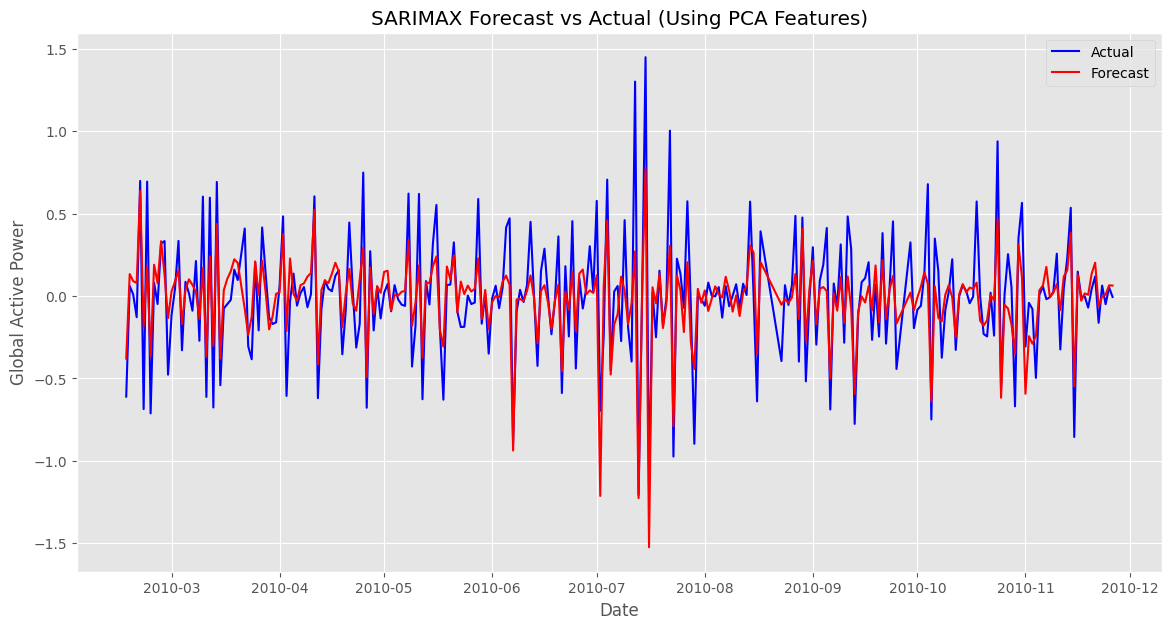

In [373]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna

# Selecting temperature-related features
temp_features = df.drop(columns=['Global_active_power','Global_active_power_ln','power_diff']).columns.tolist()
X_temp = df[temp_features]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_temp)

# Applying PCA
# Apply PCA (Retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled) # Choosing 15 components

# Convert PCA output to DataFrame and align index
X_pca_df = pd.DataFrame(X_pca, index=df.index)

# Splitting into train/test
train_size = int(len(df) * 0.8)
X_train, X_test = X_pca_df.iloc[:train_size], X_pca_df.iloc[train_size:]
y_train, y_test = df['power_diff'].iloc[:train_size], df['power_diff'].iloc[train_size:]

# === SARIMAX Model with PCA Features ===
def sarimax_objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = trial.suggest_int('s', 12, 24)  # Seasonal period (e.g., daily or monthly)

    try:
        model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train)
        model_fit = model.fit()
        return model_fit.aic
    except:
        return float('inf')

# Optimize SARIMAX parameters
study = optuna.create_study(direction='minimize')
study.optimize(sarimax_objective, n_trials=50)

# Best parameters
best_params = study.best_params
print(f"Best SARIMAX parameters: p={best_params['p']}, d={best_params['d']}, q={best_params['q']}, P={best_params['P']}, D={best_params['D']}, Q={best_params['Q']}, s={best_params['s']}")

# Fit the SARIMAX model with best parameters
best_model = SARIMAX(y_train, order=(best_params['p'], best_params['d'], best_params['q']),
                      seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
                      exog=X_train)
best_model_fit = best_model.fit()

# Forecasting
forecast = best_model_fit.forecast(steps=len(y_test), exog=X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.title('SARIMAX Forecast vs Actual (Using PCA Features)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


           Date  Forecasted_Global_Active_Power
1098 2010-11-27                       -0.379688
1099 2010-11-28                        0.133348
1100 2010-11-29                        0.090469
1101 2010-11-30                        0.079545
1102 2010-12-01                        0.638831
1103 2010-12-02                       -0.184687
1104 2010-12-03                        0.181431
1105 2010-12-04                       -0.364391
1106 2010-12-05                        0.189883
1107 2010-12-06                        0.078805
1108 2010-12-07                        0.333085
1109 2010-12-08                        0.128295
1110 2010-12-09                       -0.134217
1111 2010-12-10                        0.027382
1112 2010-12-11                        0.089176


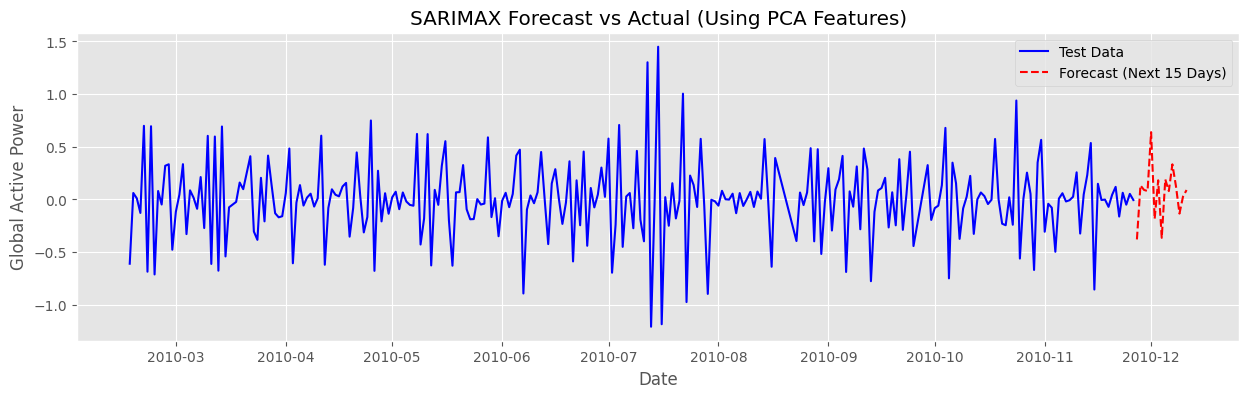

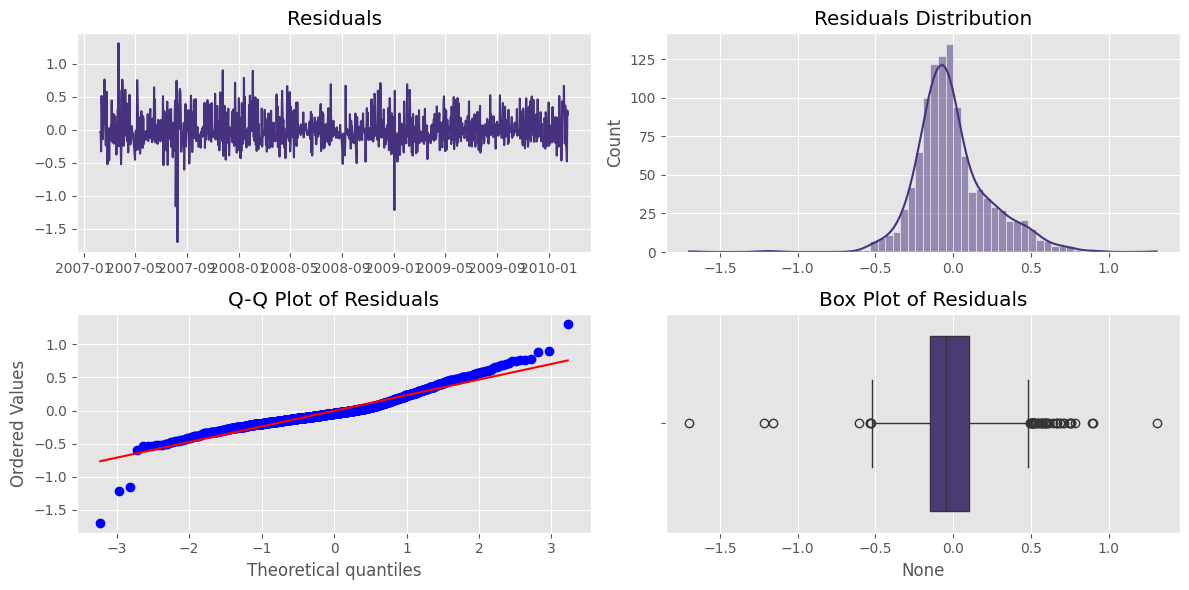

In [374]:
# Forecasting only 15 days
forecast_steps = 15  # Forecasting only 15 days
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps+1, freq='D')[1:]  # Generate future dates
# Train the SARIMAX model with the best parameters
best_model = SARIMAX(y_train, order=(best_params['p'], best_params['d'], best_params['q']),
                      seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']),
                      exog=X_train)
best_model_fit = best_model.fit()
# Ensure exog for forecasting has correct shape
X_test_forecast = X_test[:forecast_steps]
if X_test_forecast.shape[0] < forecast_steps:
    last_row = X_test_forecast.iloc[[-1]]
    rows_needed = forecast_steps - X_test_forecast.shape[0]
    X_test_forecast = pd.concat([X_test_forecast, pd.concat([last_row]*rows_needed, ignore_index=True)], ignore_index=True)
    X_test_forecast.index = range(X_test_forecast.shape[0])
forecast = best_model_fit.forecast(steps=forecast_steps, exog=X_test_forecast)
# Convert forecasted values into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Global_Active_Power': forecast
})
# Display the forecasted values
print(forecast_df)
# Plot the results
plt.figure(figsize=(15, 4))
plt.plot(y_test.index, y_test, label='Test Data', color='blue')
plt.plot(forecast_index, forecast, label='Forecast (Next 15 Days)', color='red', linestyle='dashed')
plt.title('SARIMAX Forecast vs Actual (Using PCA Features)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()
# Model diagnostics
residuals = best_model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.subplot(2, 2, 4)
sns.boxplot(x=residuals)
plt.title('Box Plot of Residuals')
plt.tight_layout()
plt.show()

### LSTM Model

[I 2025-06-10 10:35:07,112] A new study created in memory with name: no-name-605fe3a6-3ccb-4c5b-a939-f20d82b850d0
[I 2025-06-10 10:37:35,349] Trial 0 finished with value: 0.08528023213148117 and parameters: {'lstm_units': 87, 'learning_rate': 0.004819130628916177, 'dropout_rate': 0.4595438856183288, 'batch_size': 32}. Best is trial 0 with value: 0.08528023213148117.
[I 2025-06-10 10:38:00,279] Trial 1 finished with value: 0.15129344165325165 and parameters: {'lstm_units': 66, 'learning_rate': 0.006775723854688454, 'dropout_rate': 0.35509105254066375, 'batch_size': 64}. Best is trial 0 with value: 0.08528023213148117.
[I 2025-06-10 10:38:16,656] Trial 2 finished with value: 0.15253563225269318 and parameters: {'lstm_units': 41, 'learning_rate': 0.0016881134215106603, 'dropout_rate': 0.1257800242685609, 'batch_size': 32}. Best is trial 0 with value: 0.08528023213148117.
[I 2025-06-10 10:39:20,798] Trial 3 finished with value: 0.1525585651397705 and parameters: {'lstm_units': 113, 'learni

Epoch 1/150
27/27 [==============================] - 7s 118ms/step - loss: 1.1866 - val_loss: 0.1540 - lr: 0.0099
Epoch 2/150
27/27 [==============================] - 2s 86ms/step - loss: 0.4462 - val_loss: 0.1528 - lr: 0.0099
Epoch 3/150
27/27 [==============================] - 2s 85ms/step - loss: 0.2703 - val_loss: 0.1502 - lr: 0.0099
Epoch 4/150
27/27 [==============================] - 2s 91ms/step - loss: 0.2136 - val_loss: 0.1526 - lr: 0.0099
Epoch 5/150
27/27 [==============================] - 2s 89ms/step - loss: 0.1671 - val_loss: 0.1506 - lr: 0.0099
Epoch 6/150
27/27 [==============================] - 2s 91ms/step - loss: 0.1609 - val_loss: 0.1489 - lr: 0.0099
Epoch 7/150
27/27 [==============================] - 2s 92ms/step - loss: 0.1372 - val_loss: 0.1458 - lr: 0.0099
Epoch 8/150
27/27 [==============================] - 2s 91ms/step - loss: 0.1362 - val_loss: 0.1449 - lr: 0.0099
Epoch 9/150
27/27 [==============================] - 2s 91ms/step - loss: 0.1318 - val_loss: 0.

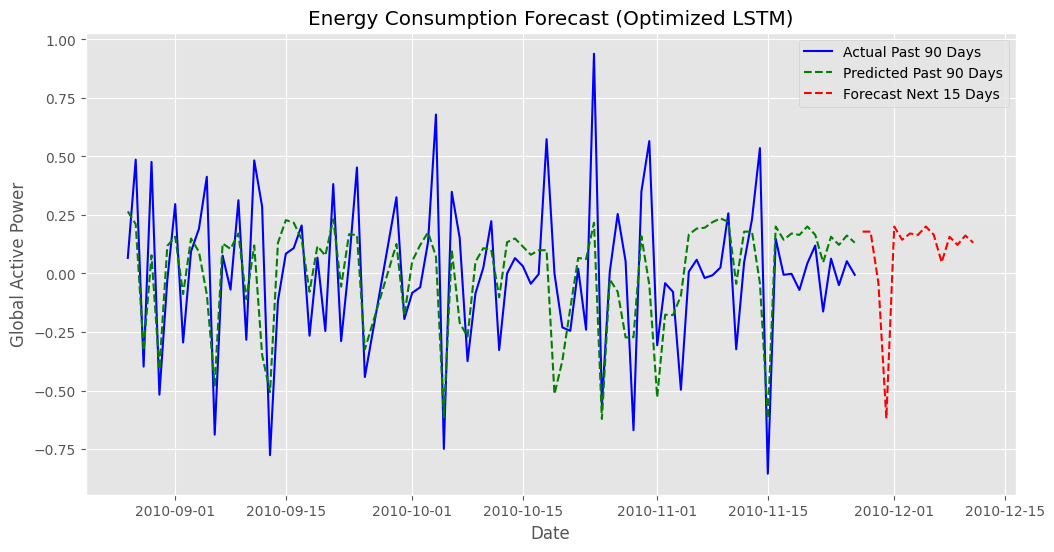

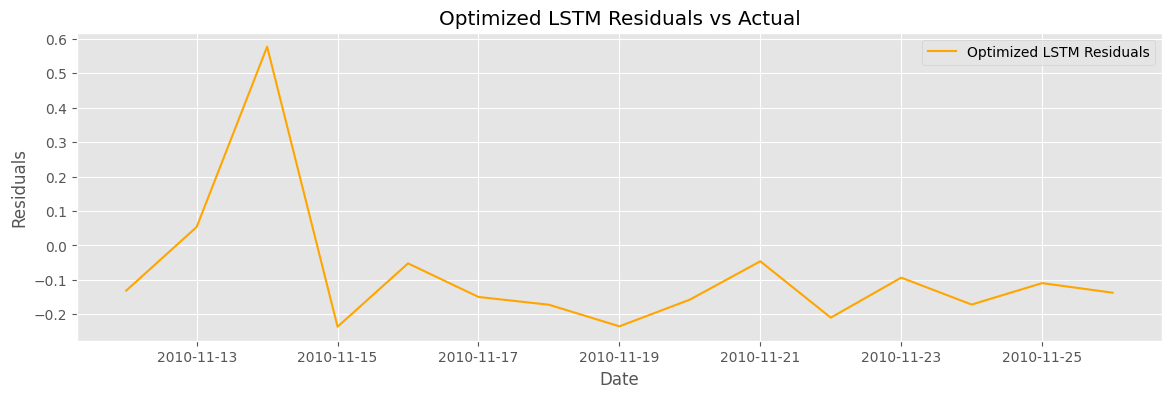

In [320]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import matplotlib.pyplot as plt

df_Rnn = df.copy()
df_Rnn=df_Rnn.dropna()
# Select only relevant features (temperature, humidity, season, etc.)
feature_columns =['Global_active_power', 'Global_active_power_ln', 'power_diff']
X = df_Rnn[feature_columns]
y = df_Rnn['power_diff']  # Target variable

# Train-test split (80-20)
train_size = int(len(df_Rnn) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalize features for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences for LSTM
def create_sequences(X, y, n_steps=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 30  # 30-day window
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, n_steps)

# === LSTM Optimization ===
def objective_lstm(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(n_steps, X_train_seq.shape[2])),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]
    
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_seq, y_train_seq, test_size=0.2, shuffle=False)
    
    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=batch_size, verbose=0, callbacks=callbacks
    )
    
    return min(history.history['val_loss'])

study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=20)
best_lstm_params = study_lstm.best_params

# Train final LSTM model
final_model = Sequential([
    LSTM(best_lstm_params['lstm_units'], return_sequences=True, input_shape=(n_steps, X_train_seq.shape[2])),
    BatchNormalization(),
    Dropout(best_lstm_params['dropout_rate']),
    LSTM(best_lstm_params['lstm_units'] // 2),
    BatchNormalization(),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(1)
])

final_model.compile(optimizer=Adam(learning_rate=best_lstm_params['learning_rate']), loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5)
]

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_seq, y_train_seq, test_size=0.2, shuffle=False)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=150, batch_size=best_lstm_params['batch_size'], verbose=1, callbacks=callbacks
)

# Forecasting horizon (Next 15 days)
forecast_steps = 15
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps+1, freq='D')[1:]

# **Fix: Ensure rolling forecasting correctly propagates predictions**
future_features = X_test_seq[-forecast_steps:].copy()  # Start with last known features
future_predictions_lstm = []

for i in range(forecast_steps):
    pred = final_model.predict(future_features[[i]])[0, 0]
    future_predictions_lstm.append(pred)

# **Fix: Ensure correct alignment of forecasted values**
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Global_Active_Power': future_predictions_lstm
})
forecast_df.set_index('Date', inplace=True)

# **Fix: Ensure correct alignment in the plot**
past_90_days_actual = df[['power_diff']].iloc[-90:].copy()
past_90_days_actual.index = pd.to_datetime(past_90_days_actual.index)

past_90_days_predicted = pd.DataFrame({
    'Date': past_90_days_actual.index,
    'Predicted_Global_Active_Power': final_model.predict(X_test_seq[-90:]).flatten()
})
past_90_days_predicted.set_index('Date', inplace=True)

# **Plot the results correctly**
plt.figure(figsize=(12, 6))

# Plot past 90 days of actual data
plt.plot(past_90_days_actual.index, past_90_days_actual['power_diff'], label='Actual Past 90 Days', color='blue')

# Plot past 90 days of predicted values
plt.plot(past_90_days_predicted.index, past_90_days_predicted['Predicted_Global_Active_Power'], label='Predicted Past 90 Days', linestyle='dashed', color='green')

# Plot forecasted values with correct alignment
plt.plot(forecast_df.index, forecast_df['Forecasted_Global_Active_Power'], label='Forecast Next 15 Days', linestyle='dashed', color='red')

plt.title('Energy Consumption Forecast (Optimized LSTM)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

# **Fix: Ensure residuals are correctly plotted**
plt.figure(figsize=(14, 4))
plt.plot(y_test.index[-forecast_steps:], y_test.iloc[-forecast_steps:] - future_predictions_lstm, label='Optimized LSTM Residuals', color='orange')
plt.title('Optimized LSTM Residuals vs Actual')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()




In [321]:
#evaluate the metrix
mae= mean_absolute_error(y_test.iloc[-forecast_steps:], future_predictions_lstm)
mse = mean_squared_error(y_test.iloc[-forecast_steps:], future_predictions_lstm)
r2 = r2_score(y_test.iloc[-forecast_steps:], future_predictions_lstm)
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

MAE: 0.1690, MSE: 0.0440, R2: 0.4279


### Prophet Model


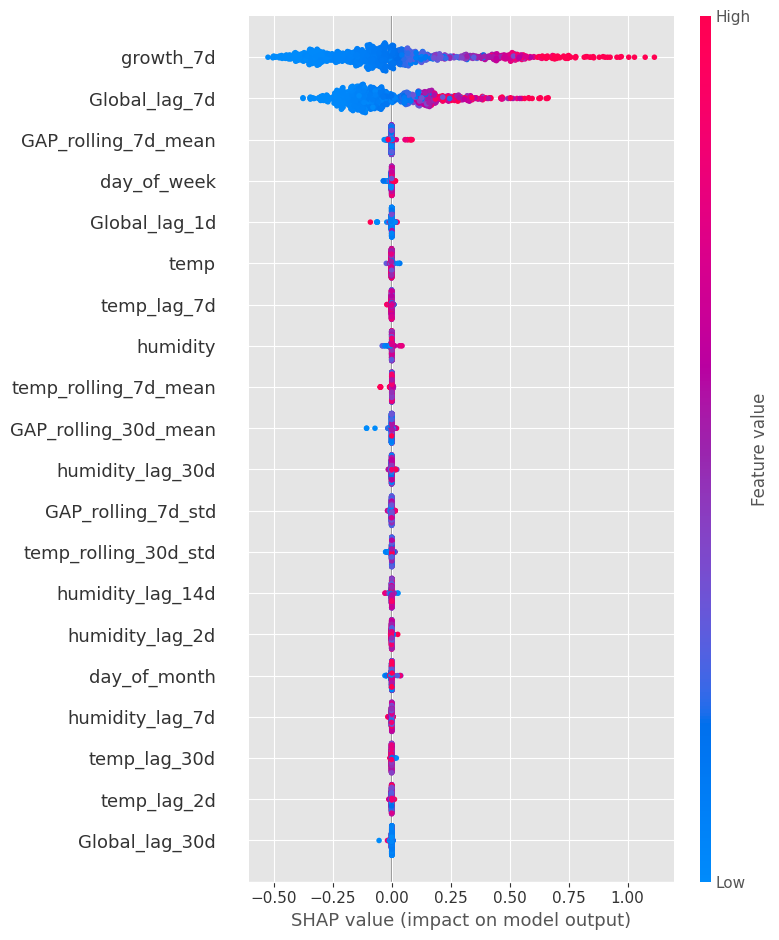

In [355]:
#%pip install shap
import shap
import xgboost

X= df.drop(columns=['Global_active_power', 'Global_active_power_ln', 'power_diff'])
y = df['Global_active_power_ln']
# Train-test split
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
# Train an XGBoost model
xgb_model = xgboost.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Explain model using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_train)

# Check feature importance
importance = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
#print(importance_df)

# Select top 10 features based on SHAP values
top_features = importance_df.head(15)['Feature'].tolist()

[I 2025-06-10 17:11:05,919] A new study created in memory with name: no-name-e1b4322d-958e-42c4-b537-010d28f5a870
[I 2025-06-10 17:11:06,425] Trial 0 finished with value: 0.1481892301527582 and parameters: {'changepoint_prior_scale': 0.009743112098165247, 'seasonality_prior_scale': 0.09618294228323093, 'holidays_prior_scale': 1.6484666014151477, 'changepoint_range': 0.9194689937424996}. Best is trial 0 with value: 0.1481892301527582.
[I 2025-06-10 17:11:06,928] Trial 1 finished with value: 0.16543727412748535 and parameters: {'changepoint_prior_scale': 0.35419020730228995, 'seasonality_prior_scale': 0.9655975754233068, 'holidays_prior_scale': 0.012582977672428853, 'changepoint_range': 0.9078998531654952}. Best is trial 0 with value: 0.1481892301527582.
[I 2025-06-10 17:11:07,380] Trial 2 finished with value: 0.14836027265425794 and parameters: {'changepoint_prior_scale': 0.002763742876078052, 'seasonality_prior_scale': 9.145014813000657, 'holidays_prior_scale': 5.761891860855241, 'chan

Best Prophet parameters: {'changepoint_prior_scale': 0.01947955107938748, 'seasonality_prior_scale': 0.010104233030345435, 'holidays_prior_scale': 1.6863862275067834, 'changepoint_range': 0.8921225198331892}
Final Model Performance: MAE=0.1506, MSE=0.0424, R2=0.4387
         Date  Forecasted_Global_Active_Power
0  2010-11-27                        1.617155
1  2010-11-28                        1.626368
2  2010-11-29                        1.511770
3  2010-11-30                        1.508988
4  2010-12-01                        1.582847
5  2010-12-02                        1.447422
6  2010-12-03                        1.482561
7  2010-12-04                        1.591780
8  2010-12-05                        1.622077
9  2010-12-06                        1.509378
10 2010-12-07                        1.502033
11 2010-12-08                        1.519078
12 2010-12-09                        1.430039
13 2010-12-10                        1.519385
14 2010-12-11                        1.4479

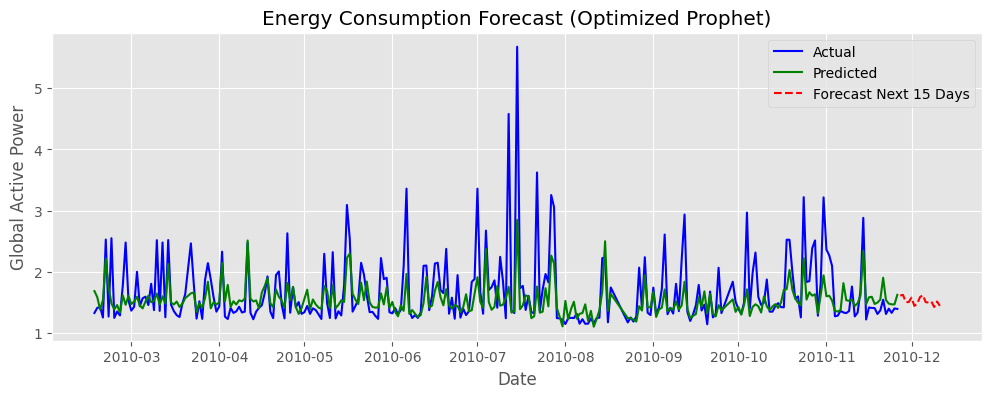

In [386]:

from prophet import Prophet

df_prop = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
df_clean = df_prop.dropna()


X_selected = df_clean[top_features]
y = df_clean[['Global_active_power_ln']]  # Target variable

# Split data into train and test
train_size = int(len(df_clean) * 0.8)  # 75% for training
X_train, X_test = X_selected.iloc[:train_size], X_selected.iloc[train_size:]
y_train = y.iloc[:train_size].copy()
y_test = y.iloc[train_size:].copy()

# Reset index & format data for Prophet
y_train = y_train.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power_ln': 'y'})
y_test = y_test.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power_ln': 'y'})

# Create lagged features for better forecasting stability
y_train['lag_1'] = y_train['y'].shift(1).fillna(y_train['y'].mean())
y_train['lag_2'] = y_train['y'].shift(2).fillna(y_train['y'].mean())

y_test['lag_1'] = y_test['y'].shift(1).fillna(y_test['y'].mean())
y_test['lag_2'] = y_test['y'].shift(2).fillna(y_test['y'].mean())

# Scale feature values before adding them to Prophet
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled values back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=top_features, index=y_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=top_features, index=y_test.index)

# Add important features as external regressors
for feature in top_features:
    y_train[feature] = X_train[feature].values
    y_test[feature] = X_test[feature].values

# === Optuna Optimization for Prophet ===
def prophet_objective(trial):
    # Hyperparameter search space
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10),
        'changepoint_range': trial.suggest_uniform('changepoint_range', 0.85, 0.95),  # Adjusting trend sensitivity
    }
    
    # Define Prophet model
    prop_model = Prophet(**params)
    
    # Add regressors
    for feature in top_features:
        prop_model.add_regressor(feature)
       

    # Fit model
    prop_model.fit(y_train)
    forecast = prop_model.predict(y_test)

    return mean_absolute_error(y_test['y'], forecast['yhat'])  # Optuna minimizes MAE

# Optimize Prophet parameters
study = optuna.create_study(direction='minimize')
study.optimize(prophet_objective, n_trials=50)

# Best parameters from Optuna
best_params = study.best_params
print(f"Best Prophet parameters: {best_params}")

# Train final model with best parameters
best_prop_model = Prophet(**best_params)
# Add regressors
for feature in top_features:
    best_prop_model.add_regressor(feature)
    best_prop_model.add_regressor('lag_1')
    best_prop_model.add_regressor('lag_2')
    best_prop_model.add_seasonality(name='monthly', period=30.5, fourier_order=20)  # Adding monthly seasonality
best_prop_model.fit(y_train)

# Forecast for the next 15 days
future_steps = 15
future_dates = pd.date_range(start=y_test['ds'].iloc[-1], periods=future_steps+1, freq='D')[1:]
future_df = pd.DataFrame({'ds': future_dates})

# Include last known values of important features for forecasting
for feature in top_features:
    future_df[feature] = X_test[feature].iloc[-1]  # Using last known values

# Add lagged features to future_df using last known values from y_test
future_df['lag_1'] = y_test['lag_1'].iloc[-1]
future_df['lag_2'] = y_test['lag_2'].iloc[-1]

forecast = best_prop_model.predict(future_df)

# Convert forecasted values back from log scale
forecast['Forecasted_Global_Active_Power'] = np.exp(forecast['yhat'])

# Evaluate model performance
mae = mean_absolute_error(y_test['y'], best_prop_model.predict(y_test)['yhat'])
mse = mean_squared_error(y_test['y'], best_prop_model.predict(y_test)['yhat'])
r2 = r2_score(y_test['y'], best_prop_model.predict(y_test)['yhat'])
print(f"Final Model Performance: MAE={mae:.4f}, MSE={mse:.4f}, R2={r2:.4f}")

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Global_Active_Power': forecast['Forecasted_Global_Active_Power']
})
print(forecast_df)
# Plot forecast results
plt.figure(figsize=(12, 4))
plt.plot(y_test['ds'], np.exp(y_test['y']), label='Actual', color='blue')
# Fix: Select 'yhat' column before applying np.exp
predicted = best_prop_model.predict(y_test)
plt.plot(y_test['ds'], np.exp(predicted['yhat']), label='Predicted', color='green')
plt.plot(forecast['ds'], forecast['Forecasted_Global_Active_Power'], label='Forecast Next 15 Days', linestyle='dashed', color='red')

plt.title("Energy Consumption Forecast (Optimized Prophet)")
plt.xlabel("Date")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()

### XGboost Model

[I 2025-06-10 09:47:22,862] A new study created in memory with name: no-name-31a092fb-ea21-4875-a315-c0f6667f2118
[I 2025-06-10 09:47:23,497] Trial 0 finished with value: 0.10363180063958145 and parameters: {'n_estimators': 143, 'max_depth': 7, 'learning_rate': 0.08235122296408298}. Best is trial 0 with value: 0.10363180063958145.
[I 2025-06-10 09:47:24,081] Trial 1 finished with value: 0.11043399117951802 and parameters: {'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.07219687542866854}. Best is trial 0 with value: 0.10363180063958145.
[I 2025-06-10 09:47:24,332] Trial 2 finished with value: 0.152641306472975 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.010484835194271586}. Best is trial 0 with value: 0.10363180063958145.
[I 2025-06-10 09:47:26,577] Trial 3 finished with value: 0.12675804471684815 and parameters: {'n_estimators': 179, 'max_depth': 10, 'learning_rate': 0.019772477618373724}. Best is trial 0 with value: 0.10363180063958145.
[I 2025-06

Optimized XGBoost - MAE: 0.0486, RMSE: 0.0750, R²: 0.9593


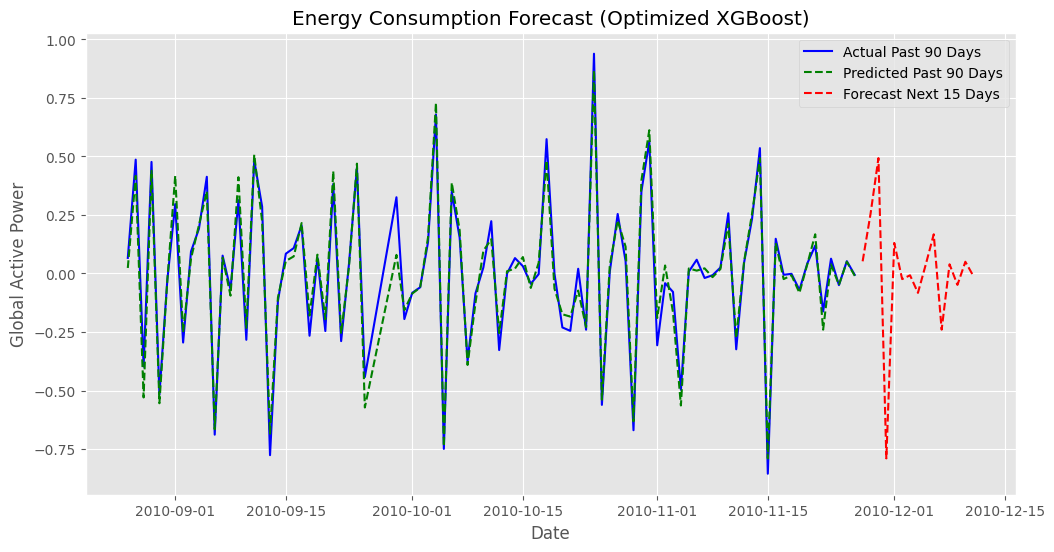

"# Plot the residuals\nplt.figure(figsize=(14, 4))\nplt.plot(y_test.index[-forecast_steps:], y_test.iloc[-forecast_steps:] - future_predictions_xgb, label='Optimized XGBoost Residuals', color='orange')\nplt.title('Optimized XGBoost Residuals vs Actual')\nplt.xlabel('Date')\nplt.ylabel('Residuals')\nplt.legend()\nplt.show()"

In [ ]:
import xgboost as xgb
df1=df.copy()
df1=df1.dropna()  # Ensure no NaNs before proceeding
X=df1.drop(columns=['Global_active_power', 'Global_active_power_ln','power_diff'])  # Drop non-target columns
y = df1[['power_diff']].dropna()  # Use only target variable

# Train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalize features for XGBoost
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === XGBoost Optimization ===
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    return np.sqrt(mean_squared_error(y_test, preds))

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)
best_xgb_params = study_xgb.best_params

# Train final XGBoost model
xgb_model = xgb.XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb_final = xgb_model.predict(X_test_scaled)

# Evaluate Model Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_final)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_final))
r2_xgb = r2_score(y_test, y_pred_xgb_final)

print(f"Optimized XGBoost - MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

# Forecasting horizon (Next 15 days)
forecast_steps = 15
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps+1, freq='D')[1:]

# **Fix: Ensure rolling forecasting correctly propagates predictions**
future_features = X_test_scaled[-forecast_steps:].copy()  # Start with last known features
future_predictions_xgb = []

for i in range(forecast_steps):
    pred = xgb_model.predict(future_features[[i]])[0]
    future_predictions_xgb.append(pred)

# **Fix: Ensure correct alignment of forecasted values**
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Global_Active_Power': future_predictions_xgb
})
forecast_df.set_index('Date', inplace=True)

# **Fix: Ensure correct alignment in the plot**
past_90_days_actual = df[['power_diff']].iloc[-90:].copy()
past_90_days_actual.index = pd.to_datetime(past_90_days_actual.index)

past_90_days_predicted = pd.DataFrame({
    'Date': past_90_days_actual.index,
    'Predicted_Global_Active_Power': y_pred_xgb_final[-90:]  # Last 90 days of predictions
})
past_90_days_predicted.set_index('Date', inplace=True)

# **Plot the results correctly**
plt.figure(figsize=(12, 6))

# Plot past 90 days of actual data
plt.plot(past_90_days_actual.index, past_90_days_actual['power_diff'], label='Actual Past 90 Days', color='blue')

# Plot past 90 days of predicted values
plt.plot(past_90_days_predicted.index, past_90_days_predicted['Predicted_Global_Active_Power'], label='Predicted Past 90 Days', linestyle='dashed', color='green')
# Plot forecasted values with correct alignment
plt.plot(forecast_df.index, forecast_df['Forecasted_Global_Active_Power'], label='Forecast Next 15 Days', linestyle='dashed', color='red')
plt.title('Energy Consumption Forecast (Optimized XGBoost)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

"""# Plot the residuals
plt.figure(figsize=(14, 4))
plt.plot(y_test.index[-forecast_steps:], y_test.iloc[-forecast_steps:] - future_predictions_xgb, label='Optimized XGBoost Residuals', color='orange')
plt.title('Optimized XGBoost Residuals vs Actual')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()"""
